Extracting Features from Text

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import pandas as pd

nltk.download("punkt")

# Your transcript dictionary
output_texts = {
    "clip_1": "Umm... I was going to the... the thing... store. Then I came back. But wait... maybe I forgot something.",
    "clip_2": "I had breakfast with... uh... someone... I don’t remember. He lives next door I think.",
    "clip_3": "It was a nice day. I walked to the park. Or maybe... maybe it was the post office.",
    "clip_4": "I, I, I don't know what I was saying... um... where was I?",
    "clip_5": "I picked up the... uh... the round thing... you know, the fruit... apple.",
    "clip_6": "She gave me the... um... I forgot what it's called... the... you use it to stir.",
    "clip_7": "Yesterday I was... and the phone rang but it wasn’t... I didn’t answer.",
    "clip_8": "I watched the microwave... no wait, I meant the movie.",
    "clip_9": "The... the thing I said... I was trying to—no, I mean... forget it.",
    "clip_10": "I needed to go to... oh look, the dog is barking again... I forgot."
}

# Define hesitation/filler words
hesitation_words = ['uh', 'um', 'umm', 'erm', 'err']

# Feature extraction function
def extract_text_features(transcripts):
    features = []

    for clip_id, text in transcripts.items():
        tokens = word_tokenize(text.lower())
        word_count = len(tokens)
        hesitation_count = sum(tokens.count(h) for h in hesitation_words)
        sentence_count = len(sent_tokenize(text))
        avg_words_per_sentence = word_count / sentence_count if sentence_count else 0

        word_freq = Counter(tokens)
        repeated_words = sum(1 for w, c in word_freq.items() if c > 1)

        sentence_complete = int(all(sent.strip().endswith(('.', '?', '!')) for sent in sent_tokenize(text)))

        features.append({
            "clip_id": clip_id,
            "word_count": word_count,
            "sentence_count": sentence_count,
            "avg_words_per_sentence": round(avg_words_per_sentence, 2),
            "hesitation_count": hesitation_count,
            "repeated_words": repeated_words,
            "sentence_complete": sentence_complete
        })

    return pd.DataFrame(features)

# Running  it
df_features = extract_text_features(output_texts)

# Showing  results as 
print("✅ Extracted Text Features:")
print(df_features)


✅ Extracted Text Features:
   clip_id  word_count  sentence_count  avg_words_per_sentence  \
0   clip_1          26               4                    6.50   
1   clip_2          22               3                    7.33   
2   clip_3          22               3                    7.33   
3   clip_4          19               1                   19.00   
4   clip_5          19               1                   19.00   
5   clip_6          22               2                   11.00   
6   clip_7          20               2                   10.00   
7   clip_8          13               1                   13.00   
8   clip_9          18               2                    9.00   
9  clip_10          18               2                    9.00   

   hesitation_count  repeated_words  sentence_complete  
0                 1               4                  1  
1                 1               3                  1  
2                 0               5                  1  
3                 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\veerk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Build Dataset + Preprocessing for ML

In [ ]:
from sklearn.preprocessing import StandardScaler

# Use df_features from previous step
# Dropping  clip_id (not needed for training)
X_raw = df_features.drop(columns=["clip_id"])

# Normalize all numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Optional: convert back to DataFrame for readability
import pandas as pd
df_scaled = pd.DataFrame(X_scaled, columns=X_raw.columns)
df_scaled["clip_id"] = df_features["clip_id"]

# View the scaled data
print("✅ Scaled Feature Data:")
print(df_scaled)


✅ Scaled Feature Data:
   word_count  sentence_count  avg_words_per_sentence  hesitation_count  \
0    1.865696        2.013996               -1.064450               1.0   
1    0.642289        0.953998               -0.873052               1.0   
2    0.642289        0.953998               -0.873052              -1.0   
3   -0.275267       -1.165998                1.818052               1.0   
4   -0.275267       -1.165998                1.818052               1.0   
5    0.642289       -0.106000               -0.026750               1.0   
6    0.030585       -0.106000               -0.257350              -1.0   
7   -2.110378       -1.165998                0.434451              -1.0   
8   -0.581119       -0.106000               -0.487950              -1.0   
9   -0.581119       -0.106000               -0.487950              -1.0   

   repeated_words  sentence_complete  clip_id  
0        0.777778                0.0   clip_1  
1       -0.333333                0.0   clip_2  
2      

ML Modeling – Clustering + Anomaly Detection

Part 01: Using  KMeans Clustering


In [3]:
from sklearn.cluster import KMeans

# Use scaled feature data from Step 3
X_features = df_scaled.drop(columns=["clip_id"])

# KMeans with 2 or 3 clusters (you can tune this later)
kmeans = KMeans(n_clusters=2, random_state=42)
df_scaled["kmeans_cluster"] = kmeans.fit_predict(X_features)

print("✅ KMeans Clustering Results:")
print(df_scaled[["clip_id", "kmeans_cluster"]])

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


✅ KMeans Clustering Results:
   clip_id  kmeans_cluster
0   clip_1               1
1   clip_2               1
2   clip_3               1
3   clip_4               0
4   clip_5               0
5   clip_6               1
6   clip_7               1
7   clip_8               0
8   clip_9               1
9  clip_10               1


Part 02: Using Isolation Forest (Anomaly Detection)

In [4]:
from sklearn.ensemble import IsolationForest

# Isolation Forest (treats low-scoring points as anomalies)
iso = IsolationForest(contamination=0.2, random_state=42)  # adjust contamination if needed
df_scaled["anomaly_score"] = iso.fit_predict(X_features)

# -1 = anomaly, 1 = normal
df_scaled["is_anomaly"] = df_scaled["anomaly_score"].apply(lambda x: 1 if x == -1 else 0)

print("\n🚨 Anomaly Detection Results:")
print(df_scaled[["clip_id", "is_anomaly"]])



🚨 Anomaly Detection Results:
   clip_id  is_anomaly
0   clip_1           1
1   clip_2           0
2   clip_3           0
3   clip_4           0
4   clip_5           0
5   clip_6           0
6   clip_7           0
7   clip_8           1
8   clip_9           0
9  clip_10           0


PCA Visualization Code

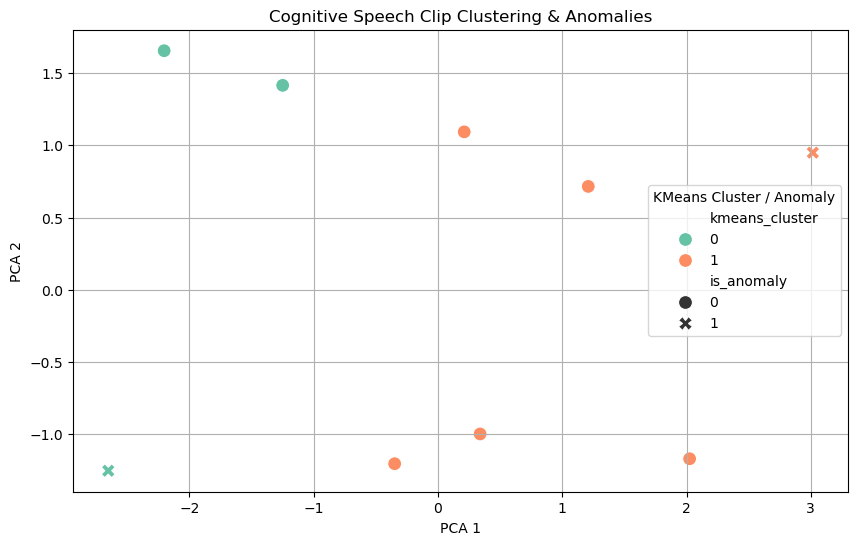

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
X_pca = PCA(n_components=2).fit_transform(X_features)

df_scaled["PCA1"] = X_pca[:, 0]
df_scaled["PCA2"] = X_pca[:, 1]

# Plot clusters + anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_scaled,
    x="PCA1",
    y="PCA2",
    hue="kmeans_cluster",
    style="is_anomaly",
    palette="Set2",
    s=100
)

plt.title("Cognitive Speech Clip Clustering & Anomalies")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="KMeans Cluster / Anomaly")
plt.grid(True)
plt.show()


In [6]:
# Add a score (just for interpretation)
df_scaled["risk_level"] = df_scaled["is_anomaly"].apply(lambda x: "High" if x == 1 else "Normal")

# Show summary
print("\n🧠 Risk Summary:")
print(df_scaled[["clip_id", "risk_level", "kmeans_cluster", "is_anomaly"]])


df_scaled.to_csv("cognitive_speech_results.csv", index=False)
print("📁 Saved results to cognitive_speech_results.csv")



🧠 Risk Summary:
   clip_id risk_level  kmeans_cluster  is_anomaly
0   clip_1       High               1           1
1   clip_2     Normal               1           0
2   clip_3     Normal               1           0
3   clip_4     Normal               0           0
4   clip_5     Normal               0           0
5   clip_6     Normal               1           0
6   clip_7     Normal               1           0
7   clip_8       High               0           1
8   clip_9     Normal               1           0
9  clip_10     Normal               1           0
📁 Saved results to cognitive_speech_results.csv


score_cognitive_risk(text)

In [11]:
def score_cognitive_risk(text):
    import nltk
    from nltk.tokenize import word_tokenize, sent_tokenize
    from collections import Counter

    hesitation_words = ['uh', 'um', 'umm', 'erm', 'err']

    # Tokenize
    tokens = word_tokenize(text.lower())
    word_count = len(tokens)
    sentence_count = len(sent_tokenize(text))
    avg_words_per_sentence = word_count / sentence_count if sentence_count else 0
    hesitation_count = sum(tokens.count(h) for h in hesitation_words)
    word_freq = Counter(tokens)
    repeated_words = sum(1 for w, c in word_freq.items() if c > 1)
    sentence_complete = int(all(sent.strip().endswith(('.', '?', '!')) for sent in sent_tokenize(text)))

    # Create input row
    row = [[
        word_count,
        sentence_count,
        avg_words_per_sentence,
        hesitation_count,
        repeated_words,
        sentence_complete
    ]]

    # Scale it
    row_scaled = scaler.transform(row)

    # Predict cluster + anomaly
    cluster = kmeans.predict(row_scaled)[0]
    anomaly = iso.predict(row_scaled)[0]
    risk = "High" if anomaly == -1 else "Normal"

    return {
        "cluster": cluster,
        "is_anomaly": 1 if anomaly == -1 else 0,
        "risk_level": risk,
        "features": {
            "word_count": word_count,
            "sentence_count": sentence_count,
            "avg_words_per_sentence": round(avg_words_per_sentence, 2),
            "hesitation_count": hesitation_count,
            "repeated_words": repeated_words,
            "sentence_complete": sentence_complete
        }
    }


Testing the model using 

In [10]:
sample_text = "I, I don't know... I forgot what I was saying... umm..."
print(score_cognitive_risk(sample_text))

{'cluster': 0, 'is_anomaly': 0, 'risk_level': 'Normal', 'features': {'word_count': 16, 'sentence_count': 2, 'avg_words_per_sentence': 8.0, 'hesitation_count': 1, 'repeated_words': 2, 'sentence_complete': 1}}


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
